In [1]:
from itertools import cycle

import pandas as pd
import bambi as bmb
import arviz as az
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from scipy.special import expit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sb
p = plt.rcParams
p["font.sans-serif"] = ["Roboto Condensed"]
p["font.weight"] = "light"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import the preprocessed data:

In [2]:
full_recid = pd.read_excel('../assets/recid_arrestation.xlsx', header=0)
full_recid.sample(10)

,id,count,age,sex,origin,prior,family,origin_org,assumed_origin
3382,4296,2,55.0,female,ABROAD,no prior,family,NL,False
2430,3048,1,41.0,female,BE,no prior,family,OV,False
1383,1719,1,56.0,female,BE,no prior,no family,GE,False
4358,5516,1,22.0,male,BE,prior,no family,PA,False
3702,4684,1,32.0,male,BXL,no prior,no family,NaN,True
2638,3320,1,57.0,male,BE,prior,no family,GE,False
4113,5200,1,18.0,male,BXL,no prior,family,BXL,False
5735,7218,1,19.0,male,BE,no prior,no family,OV,False
2513,3163,1,22.0,male,BXL,prior,no family,BXL,False
3613,4574,1,18.0,male,ABROAD,no prior,no family,FR,False


In [3]:
encoding = {
    "origin": {"BXL": "A", "BE": "B", "ABROAD": "C"},
    "family": {"no family": "A", "family": "B"},
    "sex": {"male": "A", "female": "B"},
    "prior": {"no prior": "A", "prior": "B"}
}

full_recid['origin'] = full_recid['origin'].astype('category').map(encoding["origin"])
full_recid['family'] = full_recid['family'].astype('category').map(encoding["family"])
full_recid['sex'] = full_recid['sex'].astype('category').map(encoding["sex"])
full_recid['prior'] = full_recid['prior'].astype('category').map(encoding["prior"])
full_recid.sample(10)

,id,count,age,sex,origin,prior,family,origin_org,assumed_origin
3828,4835,1,42.0,A,B,A,A,OV,False
5296,6701,1,14.0,B,A,A,B,BXL,False
3507,4451,1,32.0,A,B,A,B,BR,False
5208,6595,2,29.0,B,B,A,B,PA,False
4455,5644,1,29.0,A,A,A,B,BXL,False
5548,7002,1,40.0,A,B,A,A,BR,False
5919,7441,2,25.0,B,C,A,A,DL,False
5083,6438,1,35.0,A,B,A,A,PA,False
3929,4954,1,36.0,A,A,A,A,BXL,False
2285,2866,1,44.0,A,C,A,A,IT,False


In [4]:
print(full_recid.shape)
full_recid = full_recid[full_recid["assumed_origin"] == False]
print(full_recid.shape)

(6016, 9)
(5610, 9)


We limit the dataset to the singletons and doubletons and map the levels to binary labels:

In [5]:
print(len(full_recid))
recid = full_recid[full_recid['count'].isin((1, 2))].copy()
print(len(recid))

recid['y'] = recid['count'].map({1: 0, 2: 1})
recid['type'] = recid['y'].map({0: '$f_1$', 1: '$f_2$'})
recid['y'].value_counts()

5610
5163


y
0    4334
1     829
Name: count, dtype: int64

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


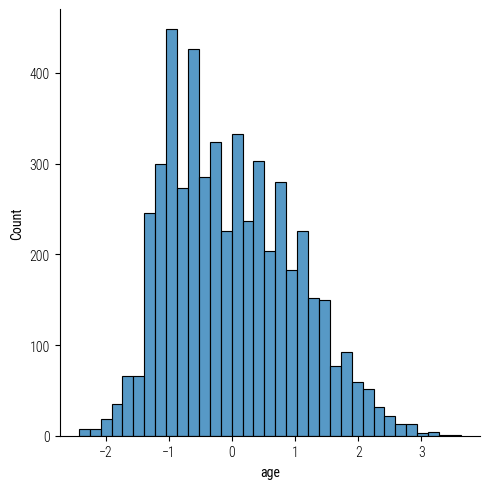

In [6]:
age_mean = np.mean(recid["age"])
age_std = np.std(recid["age"])

recid["age"] = (recid["age"] - age_mean) / age_std
recid["age2"] = recid["age"] ** 2
recid["age3"] = recid["age"] ** 3
sns.displot(recid["age"])

Doubletons are comparatively scarce, but more common in the female portion of the population:

In [7]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

color_cycle = cycle(colors)

category_colors = {}
for c in recid['type'].unique():
    category_colors[c] = next(color_cycle)

def props(key):
    p = {}
    bc = category_colors.get(key[1], 'gray')
    p['facecolor'] = bc
    p['alpha'] = 0.5
    p['linewidth'] = 3
    return p

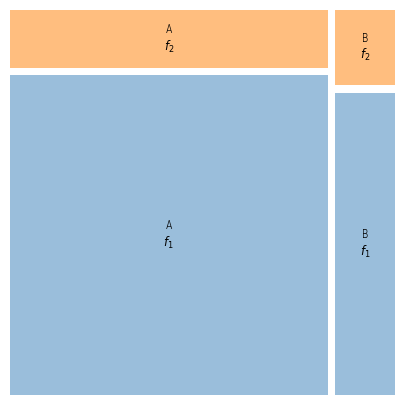

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

mosaic(data=recid, index=['sex', 'type'], gap=[0.02, 0.02],
   properties=props, 
   axes_label=False, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('../viz/mosaic_sex.png', dpi=300, transparent=True)

For origin, we can discern a similar trend:

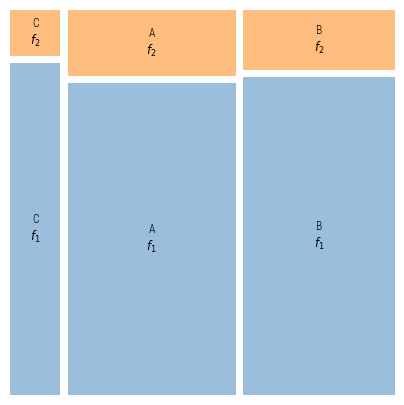

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

mosaic(data=recid, index=['origin', 'type'], gap=[0.02, 0.02],
       properties=props, axes_label=False, ax=ax);

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('../viz/mosaic_origin.png', dpi=300, transparent=True)

And for prior arrest, we see something similar:

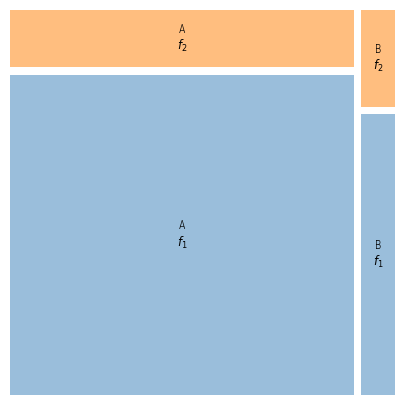

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

mosaic(data=recid, index=['prior', 'type'], gap=[0.02, 0.02],
       properties=props, axes_label=False, ax=ax);

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('../viz/mosaic_prior.png', dpi=300, transparent=True)

## Run models

In [11]:
models, fits = {}, {}

In [12]:
import re

model_strings = [
    "y ~ 1",  # intercept model,
    "y ~ 1 + age + age2",  # polynomial age model,    
    "y ~ 1 + sex",  # test for difference between sexes
    "y ~ 1 + prior",
    "y ~ 1 + origin",
    "y ~ 1 + family",
    "y ~ 1 + sex + age + age2",
    "y ~ 1 + sex + age + age2 + prior",    
    "y ~ 1 + sex + age + age2 + prior + origin",
    "y ~ 1 + sex + age + age2 + prior + origin + family",        
]

In [13]:
for model_string in model_strings:
    models[model_string] = bmb.Model(model_string, recid, family='bernoulli')
    print(model_string)
    fits[model_string] = models[model_string].fit(
        draws=2000, chains=4, inference_method='nuts_numpyro', idata_kwargs={'log_likelihood': True})

Modeling the probability that y==1


y ~ 1


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + age + age2


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + sex


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + prior


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + origin


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + family


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + sex + age + age2


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + sex + age + age2 + prior


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + sex + age + age2 + prior + origin


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Modeling the probability that y==1


y ~ 1 + sex + age + age2 + prior + origin + family


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [14]:
for model_string, fit in fits.items():
    print("=" * 80)
    print(model_string)
    print(az.summary(fit))
    print()

y ~ 1
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.654  0.038  -1.726   -1.582      0.001      0.0    2935.0   

           ess_tail  r_hat  
Intercept    3816.0    1.0  

y ~ 1 + age + age2
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.549  0.048  -1.643   -1.464      0.001      0.0    7618.0   
age        0.125  0.043   0.046    0.209      0.001      0.0    6027.0   
age2      -0.114  0.035  -0.181   -0.050      0.000      0.0    6175.0   

           ess_tail  r_hat  
Intercept    5885.0    1.0  
age          5854.0    1.0  
age2         5895.0    1.0  

y ~ 1 + sex
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.71  0.042  -1.788   -1.631      0.001    0.000    5605.0   
sex[B]     0.32  0.096   0.143    0.501      0.001    0.001    6223.0   

           ess_tail  r_hat  
Intercept    4944.0    1.0  
sex[B]       4724.0    1.0  

y ~ 1 + prior
            mean   

In [15]:
loo_compare = az.compare({model: fits[model] for model in fits}, ic='loo')

In [16]:
loo_compare.round(3)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
y ~ 1 + sex + age + age2 + prior + origin + family,0,-2242.041,7.948,0.000,0.843,43.801,0.000,False,log
y ~ 1 + sex + age + age2 + prior + origin,1,-2244.361,7.081,2.320,0.007,43.788,2.525,False,log
y ~ 1 + sex + age + age2 + prior,2,-2249.951,5.029,7.910,0.029,43.769,4.717,False,log
y ~ 1 + prior,3,-2261.635,1.983,19.594,0.047,43.666,7.199,False,log
y ~ 1 + sex + age + age2,4,-2265.155,4.027,23.114,0.000,43.710,7.591,False,log
y ~ 1 + age + age2,5,-2270.421,2.957,28.379,0.000,43.684,8.303,False,log
y ~ 1 + sex,6,-2271.474,1.980,29.433,0.050,43.658,8.759,False,log
y ~ 1 + family,7,-2271.748,1.944,29.706,0.023,43.672,8.744,False,log
y ~ 1 + origin,8,-2271.789,2.994,29.748,0.000,43.686,8.637,False,log
y ~ 1,9,-2275.857,1.006,33.816,0.000,43.637,9.308,False,log


In [17]:
loo_compare["weight"]

y ~ 1 + sex + age + age2 + prior + origin + family    8.428814e-01
y ~ 1 + sex + age + age2 + prior + origin             7.160083e-03
y ~ 1 + sex + age + age2 + prior                      2.948388e-02
y ~ 1 + prior                                         4.725775e-02
y ~ 1 + sex + age + age2                              5.874507e-16
y ~ 1 + age + age2                                    1.572048e-15
y ~ 1 + sex                                           5.011549e-02
y ~ 1 + family                                        2.310141e-02
y ~ 1 + origin                                        8.622525e-17
y ~ 1                                                 0.000000e+00
Name: weight, dtype: float64

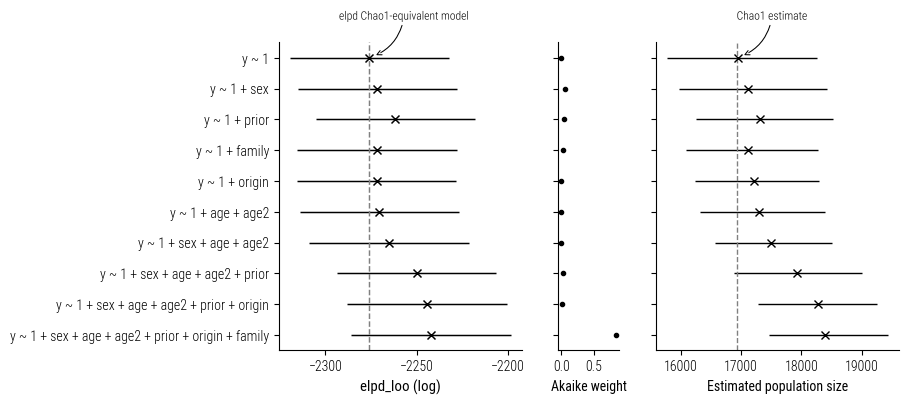

In [18]:
from copia.estimators import chao1
from copia.data import to_copia_dataset
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec

def quantile_bounds(arr, quantile=0.89):
    quantile = (1 - quantile) / 2
    lower_quantile, upper_quantile = quantile, 1 - quantile
    lower_value = np.quantile(arr, lower_quantile)
    upper_value = np.quantile(arr, upper_quantile)
    return lower_value, upper_value

def estimate_n(model, fit, ci=0.89):
    model.predict(fit, data=recid)
    trace = az.extract(fit, num_samples=2000)
    p = trace['y_mean'].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))
    N_est = N_obs + f0.sum(0)
    N_lci, N_uci = quantile_bounds(N_est, quantile=ci)
    return np.array([int(N_est.mean()), int(N_lci), int(N_uci)])

N_obs = len(full_recid['count'])

ds = to_copia_dataset(full_recid['count'], input_type="counts")
loo_compare = loo_compare.sort_index(key=lambda x: x.str.len())

ests = np.vstack([estimate_n(models[model], fits[model], ci=0.95) for model in loo_compare.index[::-1]])

fig, (loo_ax, weight_ax, est_ax) = plt.subplots(ncols=3, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [2, 0.5, 2]})

az.plot_compare(loo_compare, insample_dev=False, 
                ax=loo_ax, plot_ic_diff=False, title=False, plot_kwargs={"marker_ic": "x"},
                order_by_rank=False, textsize=10, legend=False)

text = loo_ax.annotate(
    "elpd Chao1-equivalent model", 
    (loo_compare["elpd_loo"].iloc[0], est_ax.get_yticks()[0]), 
    xycoords="data",
    xytext=(25, 30),
    textcoords="offset points",
    ha="center",
    va="center",
    size="small",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75, connectionstyle="arc3,rad=-0.3",
    ),
)

text.set_path_effects(
    [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
)
text.arrow_patch.set_path_effects(
    [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
)

weights = loo_compare["weight"]
weight_ax.plot(weights, loo_ax.get_yticks(), 'k.')
weight_ax.set(xlabel="Akaike weight")
weight_ax.spines[['right', 'top']].set_visible(False)


xerr = ests[:, 0] - ests[:, 1], ests[:, 2] - ests[:, 0]
est_ax.set(xlabel="Estimated population size")
loo_ax.set(ylabel="")
est_ax.errorbar(ests[:, 0][::-1], loo_ax.get_yticks(), xerr=xerr, 
                marker="x", linestyle="none", color="black", lw=1)
chao1_estimate = int(chao1(ds))
est_ax.axvline(chao1_estimate, ls="--", color="grey", lw=1)

text = est_ax.annotate(
    "Chao1 estimate", 
    (chao1_estimate, est_ax.get_yticks()[0]), 
    xycoords="data",
    xytext=(25, 30),
    textcoords="offset points",
    ha="center",
    va="center",
    size="small",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="black", 
        linewidth=0.75, connectionstyle="arc3,rad=-0.3",
    ),
)

est_ax.spines[['right', 'top']].set_visible(False)
loo_ax.spines[['right', 'top']].set_visible(False)

text.set_path_effects(
    [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
)
text.arrow_patch.set_path_effects(
    [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
)

fig.savefig("../viz/comparison.png", dpi=300, bbox_inches='tight')

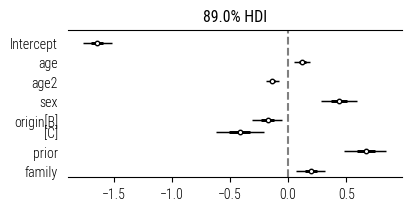

In [26]:
fig, ax = plt.subplots(figsize=(4, 2), constrained_layout=True)
az.plot_forest(fits["y ~ 1 + sex + age + age2 + prior + origin + family"], 
               kind="forestplot", hdi_prob=0.89, combined=True, ax=ax,
               var_names=["Intercept", "age", "age2", "sex", "origin", "prior", "family"],
               textsize=10, colors=["black"])
plt.axvline(0, c='grey', ls='--')
plt.savefig("../viz/covariate-model.png", dpi=300, transparent=True)

## Tabular overview

In [127]:
x, y = zip(*encoding["sex"].items())
print(x, y)

('male', 'female') ('A', 'B')


In [24]:
# moeilijke tabel, want alles enkel in relatie tot reference levels
from copia.data import to_copia_dataset
from copia.estimators import diversity

model = "y ~ 1 + sex + age + age2 + prior + origin + family"
coef = az.summary(
    fits[model], var_names=['prior', 'origin', 'sex', 'family']
)[['mean', 'hdi_3%', 'hdi_97%']]
coef['Observed'] = None
coef['Estimated'] = None
coef['Estimated_lci'] = None
coef['Estimated_uci'] = None
# coef.loc['sex[female]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['prior[no prior]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['family[family]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['origin[ABROAD]'] = ['0.0', None, None, None, None, None, None]
coef.loc['Pop. total'] = None
coef = coef.sort_index()

N_obs = len(full_recid['count'])

models[model].predict(fits[model], data=recid)
trace = az.extract(fits[model], num_samples=2000)
p = trace['y_mean'].values

l = (2 * p) / (1 - p)
f0 = (1 / (l + (l**2) / 2))
N_est = N_obs + f0.sum(0)

N_lci, N_uci = quantile_bounds(N_est)

coef.loc['Pop. total', 'Observed'] = N_obs
coef.loc['Pop. total', 'Estimated'] = int(N_est.mean())
coef.loc['Pop. total', 'Estimated_lci'] = int(N_lci)
coef.loc['Pop. total', 'Estimated_uci'] = int(N_uci)

for var in ['origin', 'sex', 'prior', 'family']:
    for level in recid[var].unique():
        # observed
        obs = len(full_recid[full_recid[var] == level])
        coef.loc[f'{var}[{level}]', 'Observed'] = obs
        # estimated
        f0 = (1 / (l + (l**2) / 2)) * (recid[var] == level).astype(int).values[:, None]
        est = obs + f0.sum(0)
        N_lci, N_uci = quantile_bounds(est)
        coef.loc[f'{var}[{level}]', 'Estimated'] = int(est.mean())
        coef.loc[f'{var}[{level}]', 'Estimated_lci'] = int(N_lci)
        coef.loc[f'{var}[{level}]', 'Estimated_uci'] = int(N_uci)

        ds = to_copia_dataset(full_recid.loc[full_recid[var] == level, "count"], input_type="counts")
        chao1_est = diversity(ds, method="chao1", CI=False, n_jobs=4, n_iter=1000)
        coef.loc[f'{var}[{level}]', 'Chao1'] = int(chao1_est)

detect_ratios = []

for o, e in zip(coef['Observed'], coef['Estimated']):
    try:
        detect_ratios.append(o / e)
    except TypeError:
        detect_ratios.append(None)
        
coef['Detection ratio'] = detect_ratios

for i, row in coef.iterrows():
    chao1_est = row["Chao1"]
    N_lci = row["Estimated_lci"]
    if chao1_est < N_lci:
        coef.loc[i, 'Estimated'] = f'${row["Estimated"]:.0f}^*$'
    else:
        coef.loc[i, 'Estimated'] = f'${row["Estimated"]:.0f}$'

ds = to_copia_dataset(full_recid["count"], input_type="counts")
chao1_est = diversity(ds, method="chao1", CI=False, n_jobs=4, n_iter=1000)
coef.loc['Pop. total', 'Chao1'] = chao1_est

coef = coef.reindex(['Pop. total', 
                     'origin[A]', 'origin[B]', 'origin[C]', 
                     'sex[A]', 'sex[B]',
                     'prior[A]', 'prior[B]',
                     'family[A]', 'family[B]',
                    ])

index = [
    ('Pop. total', ''),
    ('origin', 'BXL'),
    ('origin', 'BE'),
    ('origin', 'ABROAD'),
    ('sex', 'male'),
    ('sex', 'female'),
    ('prior', 'no'),
    ('prior', 'yes'),
    ('family', 'no'),
    ('family', 'yes')
]

coef['MA Estimate'] = coef_averaged['Estimated']
coef = coef.set_index(pd.MultiIndex.from_tuples(index, names=["", ""]))
coef = coef.round(3).fillna('--')
coef = coef[['Estimated_lci', 'Estimated_uci', 'Observed', 'Estimated', 'MA Estimate', 'Chao1', 'Detection ratio']]
coef.columns = ['$\hat{S}_{l}$', '$\hat{S}_{u}$', '$S$', '$\hat{S}$', '$\hat{S}_{\text{MA}}$', 'Chao1', 'ratio']
coef

$\hat{S}_{l}$  $\hat{S}_{u}$   $S$  $\hat{S}$  \
                                                                   
Pop. total                 17378          19513  5610    $18396$   
origin     BXL              7126           8216  2582     $7650$   
           BE               6969           8168  2275     $7536$   
           ABROAD           2737           3761   753     $3208$   
sex        male            14997          16977  4649  $15955^*$   
           female           2201           2724   961     $2441$   
prior      no              16364          18429  5100  $17348^*$   
           yes               938           1171   510     $1048$   
family     no              10714          12410  3237  $11529^*$   
           yes              6386           7390  2373     $6866$   

                  $\hat{S}_{\text{MA}}$     Chao1  ratio  
                                                          
Pop. total                        18243  16937.61  0.305  
origin     BXL                 $7700^*$   7148.00  0.338  
           BE                    $7455$   7029.00  0.302  
           ABROAD                $3089$   2982.00  0.235  
sex        male                 $15785$  14818.00  0.291  
           female                $2458$   2272.00  0.394  
prior      no                   $17160$  16299.00  0.294  
           yes                   $1084$   1007.00  0.487  
family     no                   $11325$  10688.00  0.281  
           yes                   $6918$   6409.00  0.346

In [207]:
print(coef.to_latex())

\begin{tabular}{llrrrllrr}
\toprule
 &  & $\hat{S}_{l}$ & $\hat{S}_{u}$ & $S$ & $\hat{S}$ & $\hat{S}_{	ext{MA}}$ & Chao1 & ratio \\
 &  &  &  &  &  &  &  &  \\
\midrule
Pop. total &  & 17378 & 19513 & 5610 & $18396$ & 18243 & 16937.610000 & 0.305000 \\
\cline{1-9}
\multirow[t]{3}{*}{origin} & BXL & 7126 & 8216 & 2582 & $7650$ & $7700^*$ & 7148.000000 & 0.338000 \\
 & BE & 6969 & 8168 & 2275 & $7536$ & $7455$ & 7029.000000 & 0.302000 \\
 & ABROAD & 2737 & 3761 & 753 & $3208$ & $3089$ & 2982.000000 & 0.235000 \\
\cline{1-9}
\multirow[t]{2}{*}{sex} & male & 14997 & 16977 & 4649 & $15955^*$ & $15785$ & 14818.000000 & 0.291000 \\
 & female & 2201 & 2724 & 961 & $2441$ & $2458$ & 2272.000000 & 0.394000 \\
\cline{1-9}
\multirow[t]{2}{*}{prior} & no & 16364 & 18429 & 5100 & $17348^*$ & $17160$ & 16299.000000 & 0.294000 \\
 & yes & 938 & 1171 & 510 & $1048$ & $1084$ & 1007.000000 & 0.487000 \\
\cline{1-9}
\multirow[t]{2}{*}{family} & no & 10714 & 12410 & 3237 & $11529^*$ & $11325$ & 10688.00000

## The effect of covariates

0n $p(f_2)$.

Axes(0.125,0.11;0.775x0.77)


<Axes: ylabel='$p(f_2)$'>

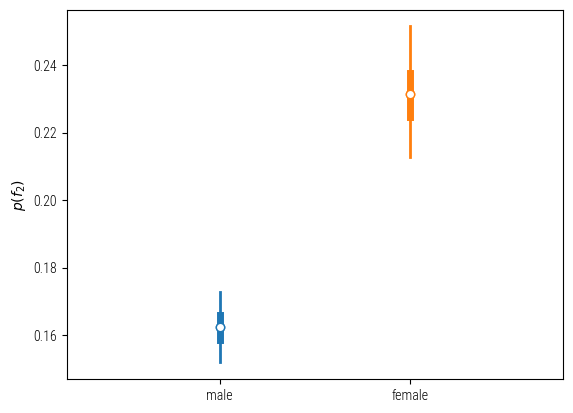

In [188]:
def plot_posterior_categorical(model, fit, var_name=None, contrast_var=None, 
                               ci_intervals=[0.95, 0.5], color="C0", ylabel=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if contrast_var is not None and var_name != contrast_var:
        ax = plot_posterior_categorical_contrastive(
            model, fit, var_name, contrast_var, ci_intervals=ci_intervals, color="C0", ylabel=ylabel, ax=ax)
    else:
        print(ax)
        ax = plot_posterior_categorical_single(
            model, fit, var_name=var_name, ci_intervals=ci_intervals, color="C0", ylabel=ylabel, ax=ax)        
    return ax

def plot_posterior_categorical_single(model, fit, var_name=None,
                               ci_intervals=[0.95, 0.5], color="C0", ylabel=None, ax=None):
    lws = 2, 5        
    value_names, values = zip(*encoding[var_name].items())
    for j, value in enumerate(values):
        new_data = pd.DataFrame({
            "sex": "A",
            "age": [0] * len(AGE),
            "age2": [0] * len(AGE),
            "family": "A",
            "prior": "A",
            "origin": "A"
        })
        new_data[var_name] = value
        
        new_idata = model.predict(fit, data=new_data, inplace=False)
        mean = new_idata.posterior["y_mean"].values.mean(0)
        for i, interval in enumerate(ci_intervals):
            ci = (1 - interval) / 2
            lower_ci, upper_ci = ci, 1 - ci
            lower_value = np.quantile(mean, lower_ci)
            upper_value = np.quantile(mean, upper_ci)
            ax.plot([j, j], [lower_value, upper_value], lw=lws[i], color=f"C{j}")
        p_est = mean.mean()
        ax.plot([j, j], [p_est, p_est], 'o', color=f"C{j}", markerfacecolor="white")
        ax.set(xlim=(-0.8, len(values) - 0.2), ylabel=ylabel)
        ax.set_xticks(np.arange(len(values)), values if value_names is None else value_names)        
    return ax
    

def plot_posterior_categorical_contrastive(model, fit, var_name=None, contrast_var=None, 
                               ci_intervals=[0.95, 0.5], color="C0", ylabel=None, ax=None):
    lws = 2, 5
    value_names, values = zip(*encoding[var_name].items())
    contrast_value_name, contrast_values = zip(*encoding[contrast_var].items())
    for k, contrast_value in enumerate(contrast_values):
        for j, value in enumerate(values):
            new_data = pd.DataFrame({
                "sex": "A",
                "age": [0] * len(AGE),
                "age2": [0] * len(AGE),
                "family": "A",
                "prior": "A",
                "origin": "A"
            })
            new_data[var_name] = value
            new_data[contrast_var] = contrast_value
            
            new_idata = model.predict(fit, data=new_data, inplace=False)
            mean = new_idata.posterior["y_mean"].values.mean(0)
            for i, interval in enumerate(ci_intervals):
                ci = (1 - interval) / 2
                lower_ci, upper_ci = ci, 1 - ci
                lower_value = np.quantile(mean, lower_ci)
                upper_value = np.quantile(mean, upper_ci)
                ax.plot([j + k * 0.1, j + k * 0.1], [lower_value, upper_value], lw=lws[i], color=f"C{k}")
            p_est = mean.mean()
            ax.plot([j + k * 0.1, j + k * 0.1], [p_est, p_est], 'o', color=f"C{k}", markerfacecolor="white")
            ax.set(xlim=(-0.8, len(values) - 0.2), ylabel=ylabel)
            ax.set_xticks(np.arange(len(values)), values if value_names is None else value_names)
        ax.set(xlim=(-0.8, len(values) - 0.2), ylabel=ylabel)
        ax.set_xticks(np.arange(len(values)), values if value_names is None else value_names)    
    return ax

plot_posterior_categorical(models[model], fits[model], "sex", "sex", ylabel="$p(f_2)$")

In [184]:
mean.mean(0).shape

(2000, 50)

Axes(0.125,0.653529;0.227941x0.226471)
Axes(0.672059,0.11;0.227941x0.226471)


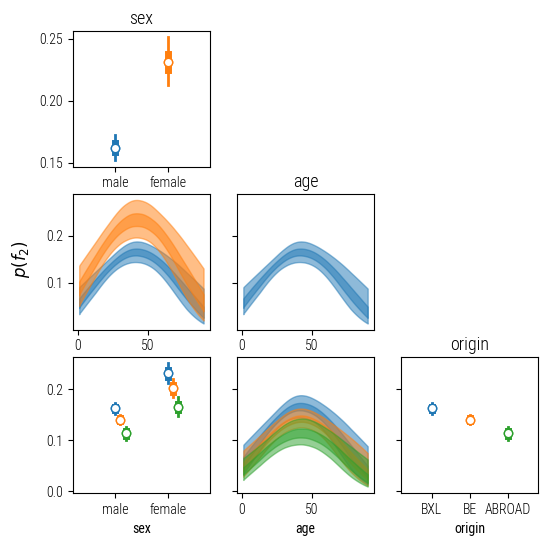

In [206]:
import itertools

model = "y ~ 1 + sex + age + age2 + prior + origin + family"

AGE = (np.linspace(1, 90) - age_mean) / age_std

predictors = {
    "sex": ("A", "B"), 
    "age": AGE,
    "origin": ("A", "B", "C")
}

fig, axes = plt.subplots(
    ncols=len(predictors), nrows=len(predictors), 
    figsize=(6, 6), sharey="row", constrained_layout=False
)
handles = []

seen_combos = set()
for i, a in enumerate(predictors):
    for j, b in enumerate(predictors):
        if frozenset([a, b]) in seen_combos:
            continue
        if a != "age" and b != "age":
            plot_posterior_categorical(
                models[model], fits[model], a, b, ax=axes[j, i])
        elif a == "age" and b == "age":
            new_data = pd.DataFrame({
                "sex": "A",
                "age": AGE,
                "age2": AGE ** 2,
                "family": "A",
                "prior": "A",
                "origin": "A", 
            })
            new_idata = models[model].predict(fits[model], data=new_data, inplace=False)
            mean = new_idata.posterior["y_mean"].values
                
            az.plot_hdi(AGE * age_std + age_mean, mean, ax=axes[i, i], color="C0", hdi_prob=0.95)        
            az.plot_hdi(AGE * age_std + age_mean, mean, ax=axes[i, i], color="C0", hdi_prob=0.5)
            # axes[i, i].plot(AGE * age_std + age_mean, mean.mean(1).mean(0), color="C0")

        else:
            var = next(iter([v for v in (a, b) if v != "age"]))
            for q, (value_name, value) in enumerate(encoding[var].items()):
                new_data = pd.DataFrame({
                    "sex": "A",
                    "age": AGE,
                    "age2": AGE ** 2,
                    "family": "A",
                    "prior": "A",
                    "origin": "A", 
                })

                new_data[var] = value
                new_idata = models[model].predict(fits[model], data=new_data, inplace=False)
                mean = new_idata.posterior["y_mean"].values
                    
                az.plot_hdi(AGE * age_std + age_mean, mean, ax=axes[j, i], color=f"C{q}", hdi_prob=0.95)        
                az.plot_hdi(AGE * age_std + age_mean, mean, ax=axes[j, i], color=f"C{q}", hdi_prob=0.5)
                # axes[j, i].plot(AGE * age_std + age_mean, mean.mean(1).mean(0), color=f"C{q}", zor)
            
        seen_combos.add(frozenset([a, b]))

for ax in axes[np.triu_indices(3, k=1)]:
    ax.set_axis_off()

fig.supylabel("$p(f_2)$");

axes[0, 0].annotate("sex", xy=(0.5, 1.05), ha="center", xycoords='axes fraction', fontweight="light", fontsize=13)
axes[1, 1].annotate("age", xy=(0.5, 1.05), ha="center", xycoords='axes fraction', fontweight="light", fontsize=13)
axes[2, 2].annotate("origin", xy=(0.5, 1.05), ha="center", xycoords='axes fraction', fontweight="light", fontsize=13)

axes[2, 0].set(xlabel="sex")
axes[2, 1].set(xlabel="age")
axes[2, 2].set(xlabel="origin")

# axes[1, 1].set_title("age", fontweight="light", pad=-50)
# axes[2, 2].set_title("origin", fontweight="light", pad=-50)
    
# axes[0, 0].set(ylabel="$p(f_2)$", title="BXL")
# axes[1, 0].set(ylabel="$p(f_2)$")
# axes[0, 1].set(title="BE")
# axes[0, 2].set(title="ABROAD")
# fig.supxlabel("Age")
# fig.legend(handles=handles[:2], labels=['male', 'female'], ncol=2, loc="upper center", bbox_to_anchor=(0.55, 1.1), frameon=False);
plt.savefig("../viz/marginal-effects.png", dpi=300, bbox_inches='tight', transparent=True)

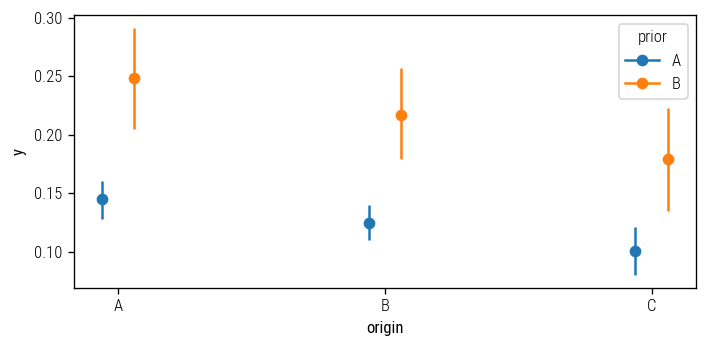

In [153]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
bmb.interpret.plot_predictions(models[model], fits[model], ['origin', 'prior'], ax=ax)
plt.tight_layout()
plt.savefig("../viz/origin_prior.png", dpi=300, transparent=True)

# Model averaging (draft)

In [157]:
weights = loo_compare["weight"]
traces = [fits[model] for model in weights.index]
model_traces = [models[model] for model in weights.index]

for model, trace in zip(model_traces, traces):
   model.predict(trace, kind="pps")

In [158]:
len_idatas = [
    idata.posterior_predictive.sizes["chain"] * idata.posterior_predictive.sizes["draw"]
    for idata in traces
]
len_idatas

[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]

In [164]:
new_samples = (np.min(len_idatas) * weights).astype(int)
new_samples

y ~ 1                                                    0
y ~ 1 + sex                                              0
y ~ 1 + prior                                           88
y ~ 1 + origin                                           0
y ~ 1 + family                                         701
y ~ 1 + age + age2                                       0
y ~ 1 + sex + age + age2                                 0
y ~ 1 + sex + age + age2 + prior                       413
y ~ 1 + sex + age + age2 + prior + origin              985
y ~ 1 + sex + age + age2 + prior + origin + family    5811
Name: weight, dtype: int64

In [169]:
new_idatas = [
    az.extract(idata, group="posterior", num_samples=samples).reset_coords()
    for samples, idata in zip(new_samples, traces)
]

In [170]:
new_idatas

[<xarray.Dataset>
 Dimensions:    (sample: 0, y_obs: 5163)
 Coordinates:
   * y_obs      (y_obs) int64 0 1 2 3 4 5 6 ... 5157 5158 5159 5160 5161 5162
   * sample     (sample) object MultiIndex
   * chain      (sample) int64 
   * draw       (sample) int64 
 Data variables:
     Intercept  (sample) float64 
     y_mean     (y_obs, sample) float64 
 Attributes:
     created_at:                  2024-06-27T10:21:27.941808
     arviz_version:               0.17.1
     inference_library:           pymc
     inference_library_version:   5.15.1
     sampling_time:               19.649499893188477
     tuning_steps:                1000
     modeling_interface:          bambi
     modeling_interface_version:  0.13.0,
 <xarray.Dataset>
 Dimensions:    (sample: 0, sex_dim: 1, y_obs: 5163)
 Coordinates:
   * sex_dim    (sex_dim) <U1 'B'
   * y_obs      (y_obs) int64 0 1 2 3 4 5 6 ... 5157 5158 5159 5160 5161 5162
   * sample     (sample) object MultiIndex
   * chain      (sample) int64 
   * draw

In [195]:
weighted_samples['posterior']['y_mean']

<xarray.DataArray 'y_mean' (y_obs: 5163, sample: 7998)>
array([[0.1521665 , 0.14194562, 0.15456152, ..., 0.12455955, 0.10494097,
        0.10214694],
       [0.1521665 , 0.14194562, 0.15456152, ..., 0.10717551, 0.12416974,
        0.13831298],
       [0.27126846, 0.21158878, 0.25885596, ..., 0.20129147, 0.22836312,
        0.22462256],
       ...,
       [0.1521665 , 0.14194562, 0.15456152, ..., 0.12279906, 0.12676241,
        0.14338337],
       [0.1521665 , 0.14194562, 0.15456152, ..., 0.12461054, 0.12818155,
        0.14433912],
       [0.1521665 , 0.14194562, 0.15456152, ..., 0.09927731, 0.11647581,
        0.13371203]])
Coordinates:
  * y_obs    (y_obs) int64 0 1 2 3 4 5 6 ... 5156 5157 5158 5159 5160 5161 5162
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 1 1 0 2 3 3 0 2 3 1 2 0 ... 0 0 1 2 2 0 0 0 1 3 0 3
  * draw     (sample) int64 1491 1229 351 1017 940 ... 1846 611 1894 1368 818

In [22]:
import xarray as xr

weights = loo_compare["weight"]
traces = [fits[model] for model in weights.index]
model_traces = [models[model] for model in weights.index]

for model, trace in zip(model_traces, traces):
   model.predict(trace, kind="pps")

len_idatas = [
    idata.posterior_predictive.sizes["chain"] * idata.posterior_predictive.sizes["draw"]
    for idata in traces
]

new_samples = (np.min(len_idatas) * weights).astype(int)
new_idatas = [
    az.extract(idata, group="posterior", num_samples=samples).reset_coords()
    for samples, idata in zip(new_samples, traces)
]

weighted_samples = az.InferenceData(
        posterior=xr.concat(new_idatas, dim="sample"),
        observed_data=traces[0].observed_data,
)

In [23]:
# moeilijke tabel, want alles enkel in relatie tot reference levels
from copia.data import to_copia_dataset
from copia.estimators import diversity

model = "y ~ 1 + sex + age + age2 + prior + origin + family"
coef = az.summary(
    fits[model], var_names=['prior', 'origin', 'sex', 'family']
)[['mean', 'hdi_3%', 'hdi_97%']]
coef['Observed'] = None
coef['Estimated'] = None
coef['Estimated_lci'] = None
coef['Estimated_uci'] = None
# coef.loc['sex[female]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['prior[no prior]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['family[family]'] = ['0.0', None, None, None, None, None, None]
# coef.loc['origin[ABROAD]'] = ['0.0', None, None, None, None, None, None]
coef.loc['Pop. total'] = None
coef = coef.sort_index()

N_obs = len(full_recid['count'])

p = weighted_samples['posterior']['y_mean'].values
l = (2 * p) / (1 - p)
f0 = (1 / (l + (l**2) / 2))
N_est = N_obs + f0.sum(0)
N_lci, N_uci = quantile_bounds(N_est, quantile=0.89)

coef.loc['Pop. total', 'Observed'] = N_obs
coef.loc['Pop. total', 'Estimated'] = int(N_est.mean())
coef.loc['Pop. total', 'Estimated_lci'] = int(N_lci)
coef.loc['Pop. total', 'Estimated_uci'] = int(N_uci)

ds = to_copia_dataset(full_recid["count"], input_type="counts")
chao1_est = diversity(ds, method="chao1", CI=False, n_jobs=4, n_iter=1000)
chao1_est = f'${chao1_est:.0f}$'
coef.loc['Pop. total', 'Chao1'] = chao1_est


for var in ['origin', 'sex', 'prior', 'family']:
    for level in recid[var].unique():
        # observed
        obs = len(full_recid[full_recid[var] == level])
        coef.loc[f'{var}[{level}]', 'Observed'] = obs
        # estimated
        f0 = (1 / (l + (l**2) / 2)) * (recid[var] == level).astype(int).values[:, None]
        est = obs + f0.sum(0)
        N_lci, N_uci = quantile_bounds(est)
        coef.loc[f'{var}[{level}]', 'Estimated_lci'] = int(N_lci)
        coef.loc[f'{var}[{level}]', 'Estimated_uci'] = int(N_uci)

        ds = to_copia_dataset(full_recid.loc[full_recid[var] == level, "count"], input_type="counts")
        chao1_est = diversity(ds, method="chao1", CI=False, n_jobs=4, n_iter=1000)
        if chao1_est < N_lci:
            coef.loc[f'{var}[{level}]', 'Estimated'] = f'${est.mean():.0f}^*$'
        else:
            coef.loc[f'{var}[{level}]', 'Estimated'] = f'${est.mean():.0f}$'
        coef.loc[f'{var}[{level}]', 'Chao1'] = int(chao1_est)

detect_ratios = []

for o, e in zip(coef['Observed'], coef['Estimated']):
    try:
        detect_ratios.append(o / e)
    except TypeError:
        detect_ratios.append(None)
        
coef['Detection ratio'] = detect_ratios

coef = coef.reindex(['Pop. total', 
                     'origin[A]', 'origin[B]', 'origin[C]', 
                     'sex[A]', 'sex[B]',
                     'prior[A]', 'prior[B]',
                     'family[A]', 'family[B]',
                    ])
coef_averaged = coef.round(3).fillna('--')
coef_averaged = coef_averaged[['Estimated_lci', 'Estimated_uci', 'Observed', 'Estimated', 'Chao1', 'Detection ratio']]
coef_averaged

,Estimated_lci,Estimated_uci,Observed,Estimated,Chao1,Detection ratio
Pop. total,16988,19426,5610,18243,$16938$,0.308
origin[A],7154,8291,2582,$7700^*$,7148,--
origin[B],6863,8098,2275,$7455$,7029,--
origin[C],2311,3734,753,$3089$,2982,--
sex[A],14475,16923,4649,$15785$,14818,--
sex[B],2188,2822,961,$2458$,2272,--
prior[A],15712,18352,5100,$17160$,16299,--
prior[B],942,1519,510,$1084$,1007,--
family[A],10011,12337,3237,$11325$,10688,--
family[B],6375,7505,2373,$6918$,6409,--


In [20]:
from copia.data import to_copia_dataset
from copia.estimators import diversity

In [23]:
ds = to_copia_dataset(full_recid["count"], input_type="counts")

AbundanceData(S_obs=5610, f1=4334, f2=829, n=7896, counts=array([1, 2, 1, ..., 1, 2, 1]))

In [26]:
chao1_ests = {}

In [30]:
chao1_ests["full"] = diversity(ds, method="chao1", CI=True, n_jobs=4, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
for sex in ("male", "female"):
    ds = to_copia_dataset(full_recid.loc[full_recid["sex"] == sex, "count"], input_type="counts")
    chao1_ests[f"sex={sex}"] = diversity(ds, method="chao1", CI=True, n_jobs=4, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
for prior in ("no prior", "prior"):
    ds = to_copia_dataset(full_recid.loc[full_recid["prior"] == prior, "count"], input_type="counts")
    chao1_ests[f"prior={prior}"] = diversity(ds, method="chao1", CI=True, n_jobs=4, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
for origin in ("BXL", "BE", "ABROAD"):
    ds = to_copia_dataset(full_recid.loc[full_recid["origin"] == origin, "count"], input_type="counts")
    chao1_ests[f"origin={origin}"] = diversity(ds, method="chao1", CI=True, n_jobs=4, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
for family in ("no family", "family"):
    ds = to_copia_dataset(full_recid.loc[full_recid["family"] == family, "count"], input_type="counts")
    chao1_ests[f"family={family}"] = diversity(ds, method="chao1", CI=True, n_jobs=4, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
pd.DataFrame(chao1_ests).T

,est,lci,uci
full,16937.609849,16209.862449,17725.740817
sex=male,14818.573164,14071.446676,15646.755176
sex=female,2272.184587,2047.509332,2522.686648
prior=no prior,16299.611145,15499.636477,17210.629570
prior=prior,1007.861912,895.845913,1142.373089
origin=BXL,7148.611655,6710.765288,7624.906797
origin=BE,7029.058104,6545.457287,7583.247827
origin=ABROAD,2982.850807,2596.911335,3468.086766
family=no family,10688.933419,10046.322834,11427.857091
family=family,6409.084138,6013.581508,6863.045327
